In [ ]:
pip install pyforest

In [ ]:
pip install SQLAlchemy

In [2]:
# Connect to the PostgreSQL database server
def sql_reading():
    from sqlalchemy import create_engine
    # connect to the PostgreSQL server
    print('Connecting to the PostgreSQL database...')
    engine = create_engine()
    df = pd.read_sql(
        "SELECT sysname, str_id, esm_v, datetime FROM battery_string WHERE sysname = 'GC01' and datetime between '2021-06-30 12:40:00' and '2021-06-30 16:40:00';", engine) 
    print(sysname_value+' is analyzed.')
    return df

# Reading the CSV file
def csv_reading(sysname):
    #all_files = sorted(glob("Users\Admin\Documents\Isabella\Advanced Analysis\esm_string\battery_string\esm_string_"+sysname+".csv"))
    if os.path.isfile("csv_string/esm_string_"+sysname+".csv"):
        frame = pd.read_csv("csv_string/esm_string_"+sysname+".csv",delimiter = ',',encoding = 'UTF-8')
        print(sysname+' is read!')                  
        return frame
    else:
        frame=pd.DataFrame()
        return frame

# Grouping strings according to esm_v
def grouping_v(df):
    conditions = [ 
        (df.esm_v<660), # 0 group
        (df.esm_v>=660) & (df.esm_v<720), # 1 group
        (df.esm_v>=720) & (df.esm_v<780), # 2 group
        (df.esm_v>=780) & (df.esm_v<840), # 3 group
        (df.esm_v>=840) # 4 group
    ]
    values = [0,1,2,3,4] 
    df2=pd.DataFrame()
    df2['datetime'] = df['datetime']
    df2['sysname'] = df['sysname']
    df2['str_id'] = df['str_id']
    df2['group_v'] = np.select(conditions,values) #group value assigning to strings
    print('Size: ',len(df2)) # printing the size of the dataframe
    return df2

# Converting datetime columns to datetime format (not needed now, it will be used for calculating the duration)
def datetime_converting(df):
    # we have 2 different datetime format in the csv files you provided me. The first is: '06/03/2020 17:30:03' ,
    # The second is like '2021-02-21 17:39:02'
    df['datetimep'] = pd.to_datetime(df.datetime, format='%m/%d/%Y %H:%M', errors='coerce') # converting the first datetime format type
    mask = df.datetimep.isnull()
    df.loc[mask, 'datetimep'] = pd.to_datetime(df[mask]['datetime'], format='%Y-%m-%d %H:%M:%S.%f',# converting the second datetime format type
                                                                                            errors='coerce')
    df = df.drop(columns='datetime')
    df.rename(columns = {'datetimep':'datetime'}, inplace = True)
    df5 = df['datetime']
    df['datetime'] = df5.dt.tz_convert('Asia/Hong_Kong') 
    df = df.sort_values(by=['str_id','sysname','group_v'])
    return df

#datetime converting for  csv
def datetime_converting_for_csv(df):
    # we have 2 different datetime format in the csv files you provided me. The first is: '06/03/2020 17:30:03' ,
    # The second is like '2021-02-21 17:39:02'
    df['datetimep'] = pd.to_datetime(df.datetime, format='%m/%d/%Y %H:%M', errors='coerce') # converting the first datetime format type
    mask = df.datetimep.isnull()
    df.loc[mask, 'datetimep'] = pd.to_datetime(df[mask]['datetime'], format='%Y-%m-%d %H:%M:%S.%f',# converting the second datetime format type
                                                                                            errors='coerce')
    df = df.drop(columns='datetime')
    df.rename(columns = {'datetimep':'datetime'}, inplace = True)
    df5 = df['datetime']
    df = df.sort_values(by=['str_id','sysname','group_v'])
    return df

# Grouping the duration rows according to time duration
def duration_grouping(df):
    conditions = [
        (df.duration<timedelta(minutes=60)),
        (timedelta(minutes=60)<=df.duration) & (df.duration<timedelta(minutes=360)),
        (timedelta(minutes=360)<=df.duration) & (df.duration<timedelta(minutes=1440)),
        (df.duration>timedelta(minutes=1440))
    ]
    values = [0,1,2,3]
    df['duration'] = np.select(conditions,values)
    return df

# Summing the row of time_difference_sum
def sum_rows(df,df2):
    df3 = []
    df_fin = pd.DataFrame()
    n=0
    for index, row in df2.iterrows():
        df3.append(df[n:index].groupby(['sysname','str_id','group_v'])['time_difference_sum'].sum().reset_index(name='duration'))
        n = index
    df_fin = pd.concat(df3,ignore_index=True)
    return df_fin

# Counting the number of appearances in one group per str_id
def counting_duration(df):
    df2 = pd.DataFrame()
    df2 = df[['sysname', 'str_id','group_v','duration']].groupby(['sysname', 'str_id','group_v','duration']).size().reset_index(name='count')
    return df2


# Creating the duration groups
def creating_duration(df):
    df.drop_duplicates()
    df2 = grouping_v(df)
    df2 = datetime_converting(df2)
    df2['time_difference_sum'] = df2.groupby('str_id')['datetime'].diff()
    conditions =  [
        df2.time_difference_sum > timedelta(minutes=15),
        df2.time_difference_sum < timedelta(minutes=0),
        df2.time_difference_sum < timedelta(minutes=15)
    ]
    values = [True,True,False]
    df2['Errors'] = np.select(conditions,values)
    df2['Index'] = np.arange(0,len(df))
    df2 = df2.set_index('Index')
    df2['time_difference_sum'].loc[df2.Errors==True] = timedelta(seconds=0)
    df3 = df2[df2.Errors==True]
    df4 = sum_rows(df2,df3) # calling the sum_rows function
    df4 = duration_grouping(df4)
    df4 = counting_duration(df4)
    return df4


# Creating the duration groups
def creating_duration_for_csv(df):
    df.drop_duplicates()
    df2 = grouping_v(df)
    df2 = datetime_converting_for_csv(df2)
    df2['time_difference_sum'] = df2.groupby('str_id')['datetime'].diff()
    conditions =  [
        df2.time_difference_sum > timedelta(minutes=15),
        df2.time_difference_sum < timedelta(minutes=0),
        df2.time_difference_sum < timedelta(minutes=15)
    ]
    values = [True,True,False]
    df2['Errors'] = np.select(conditions,values)
    df2['Index'] = np.arange(0,len(df))
    df2 = df2.set_index('Index')
    df2['time_difference_sum'].loc[df2.Errors==True] = timedelta(seconds=0)
    df3 = df2[df2.Errors==True]
    df4 = sum_rows(df2,df3) # calling the sum_rows function
    df4 = duration_grouping(df4)
    df4 = counting_duration(df4)
    return df4

# Plotting the stacked bar graph
def plotting_stacked_bar_graph(df):
    df3 = df.drop(['sysname','str_id'],axis=1).groupby(['group_v','duration']).agg({'count': 'count'})
    df3 = df3.groupby(level=0).apply(lambda x:
                    100 * x / float(x.sum())).reset_index()
    plt.rcParams["figure.figsize"] = (12,8)
    plt.style.use('ggplot')

    fig = df3.set_index(['group_v','duration'])\
        ['count'].unstack()\
        .plot.bar(stacked=True)
    fig.set_ylim([0, 100])
    plt.ylabel('Percentage')
    plt.show()
    return None


# Saving csv files in the new folder
def csv_saving(df,sysname):
    import os
    #outdir = '/Users/Admin/Documents/Akzhan/Project1' 
    outdir = './Groups_csv_files'
    outname = 'esm_string_analysis_'+str(sysname)+'.csv' # dynamic naming of csv files according to sysname
    if not os.path.exists(outdir):
        os.mkdir(outdir) # here the new folder called 'Groups_csv_files' is automatically created on your default path 
    fullname = os.path.join(outdir, outname)
    df.to_csv(fullname)# all csv files are saved in the new folder with the corresponding name
   

In [3]:
# Function to iterate all sysnames values to the script
def final_result_from_sql():
    sysname_value = ''
    df_read = pd.DataFrame()
    df_final=pd.DataFrame()
    df_concat=pd.DataFrame()
    sysname_arr = [
        "AE01"#,  "AG01",  "Andie", "BK01"#,  "BK02", 
    #"BS01",  "CC01",  "CR01",  "CR02",  "CR03", 
    #"CR04",  "CR05",  "CS01",  "CS02",  "CV01" ,
    #"CW01",  "GC01",  "GC02",  "HC01",  "HE01", 
    #"HE02",  "HH01", "HH02",  "HH03" , "HH04", 
   # "HH05" , "HH06" , "HH07" , "HH08",  "HH09", 
    #"HH10",  "HH11",  "HH12",  "PY01",  "PY02", 
   # "PY03",  "RD01",  "RD02",  "RD04",  "RD05", 
   # "RD06",  "RD07",  "RD08",  "RD09",  "RD10", 
   # "RD11",  "RD12",  "RD13",  "RD14",  "RD15" ,
    #"RD16",  "RD17",  "RD18",  "RD19",  "SP01", 
    #"SU01",  "SU02",  "SU03",  "SU04",  "Tammy"
    ]
    df_list = []
    for i in range(len(sysname_arr)): # looping sysname  for the script
        sysname_value = sysname_arr[i]
        df_read = sql_reading() # calling the function sql_reading()
        if df_read.shape[0]==0:
            print(sysname_value,' has no data!')
            continue
        df_final = creating_duration(df_read) # calling the function creating_duration()
        df_list.append(df_final)
        csv_saving(df_final,sysname_value) # calling the function csv_saving()
        print('CSV file of <',sysname_value,'> is ready!')
    df_concat = pd.concat(df_list,ignore_index=True)
    plotting_stacked_bar_graph(df_concat)# plotting the graph
    return df_concat
    

In [69]:
# Function to iterate all sysnames values to the script
def final_result_from_csv():
    sysname_value = ''
    df_read = pd.DataFrame()
    df_final=pd.DataFrame()
    df_concat=pd.DataFrame()
    sysname_arr = [
        "AE01",  "AG01",  "Andie", "BK01", "BK02", 
    #"BS01",  "CC01",  "CR01",  "CR02",  "CR03", 
    #"CR04",  "CR05",  "CS01",  "CS02",  "CV01" ,
    #"CW01",  "GC01", # "GC02",  "HC01",  "HE01", 
    #"HE02",  "HH01", "HH02",  "HH03" , "HH04", 
    #"HH05" , "HH06" , "HH07" , "HH08",  "HH09", 
    #"HH10",  "HH11",  "HH12",  "PY01",  "PY02", 
    #"PY03",  "RD01",  "RD02",  "RD04",  "RD05", 
    #"RD06",  "RD07",  "RD08",  "RD09",  "RD10", 
    #"RD11",  "RD12",  "RD13",  "RD14",  "RD15" ,
    #"RD16",  "RD17",  "RD18",  "RD19",  "SP01", 
    #"SU01",  "SU02",  "SU03",  "SU04",  "Tammy"
    ]
    df_list = []
    for i in range(len(sysname_arr)): # looping sysname  for the script
        sysname_value = sysname_arr[i].lower()
        df_read = csv_reading(sysname_value) # calling the function sql_reading()
        if df_read.shape[0]==0:
            print(sysname_value,' has no data or absent!')
            continue
        df_final = creating_duration_for_csv(df_read) # calling the function creating_duration()
        df_list.append(df_final)
        csv_saving(df_final,sysname_value) # calling the function csv_saving()
        print('CSV file of <',sysname_value,'> is ready!')
    if len(df_list) !=0:
        df_concat = pd.concat(df_list,ignore_index=True)
        plotting_stacked_bar_graph(df_concat)# plotting the graph
    return df_concat
    

In [4]:
import time
import pyforest
from datetime import timedelta
df = pd.DataFrame()
start = time.time()
df=final_result_from_sql()# running the whole function for sql input
end = time.time()
print(end - start)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Connecting to the PostgreSQL database...


TypeError: create_engine() missing 1 required positional argument: 'url'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

cw01 is read!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Size:  1048575


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

C:\Users\abylk\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

CSV file of < cw01 > is ready!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

gc01 is read!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Size:  4575653


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

C:\Users\abylk\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

CSV file of < gc01 > is ready!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

hh01 is read!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Size:  5887277


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

C:\Users\abylk\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

CSV file of < hh01 > is ready!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

rd02 is read!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Size:  1958272


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

C:\Users\abylk\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

CSV file of < rd02 > is ready!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

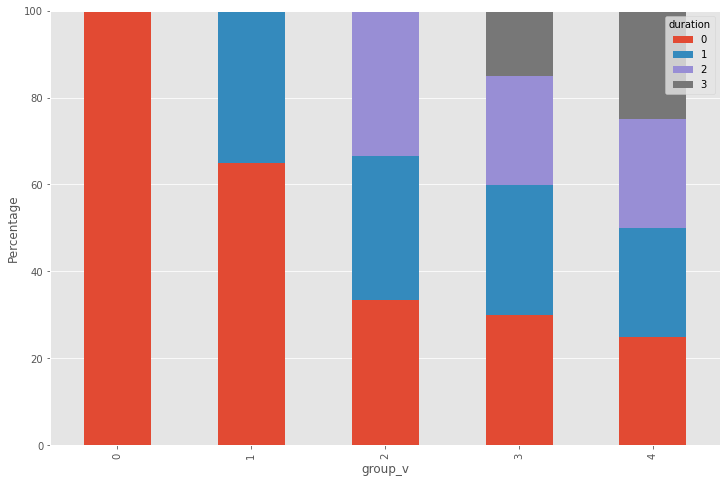

429.0827476978302


In [59]:
import time
import pyforest
from datetime import timedelta
df = pd.DataFrame()
start = time.time()
df=final_result_from_csv()# running the whole function for sql input
end = time.time()
print(end - start)

In [70]:
import time
import pyforest
from datetime import timedelta
df = pd.DataFrame()
start = time.time()
df=final_result_from_csv()# running the whole function for sql input
end = time.time()
print(end - start)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

ae01  has no data or absent!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

ag01  has no data or absent!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

andie  has no data or absent!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

bk01  has no data or absent!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

bk02  has no data or absent!
0.0249330997467041


In [17]:
rsd = get_client('redshift-data')


NameError: name 'get_client' is not defined

In [14]:
def post_process(meta, records):
    columns = [k["name"] for k in meta]
    rows = []
    for r in records:
        tmp = []
        for c in r:
            tmp.append(c[list(c.keys())[0]])
        rows.append(tmp)
    return pd.DataFrame(rows, columns=columns)
def query(sql, cluster="redshift-cluster-1", user="read", database="dev"):
    resp = rsd.execute_statement(
        Database=database,
        ClusterIdentifier=cluster,
        DbUser=user,
        Sql=sql
    )
    qid = resp["Id"]
    print(qid)
    desc = None
    while True:
        desc = rsd.describe_statement(Id=qid)
        if desc["Status"] == "FINISHED":
            break
            print(desc["ResultRows"])
    if desc and desc["ResultRows"]  > 0:
        result = rsd.get_statement_result(Id=qid)
        rows, meta = result["Records"], result["ColumnMetadata"]
        return post_process(meta, rows)

pf=query("SELECT sysname, str_id, esm_v, datetime FROM battery_string WHERE sysname = 'GC01' and datetime between '2021-06-30 12:40:00' and '2021-06-30 16:40:00';")
print(pf)

NameError: name 'rsd' is not defined

In [24]:
import redshift_connector

# Connects to Redshift cluster using IAM credentials from default profile defined in ~/.aws/credentials
conn = redshift_connector.connect(
    iam=True,
    database='dev',
    db_user='ae',
    password='',
    user='',
    cluster_identifier='cluster-1',
    #access_key_id="my_aws_access_key_id",
    #secret_access_key="my_aws_secret_access_key",
    #session_token="my_aws_session_token",
    #region="us-east-2"
 )

InterfaceError: Invalid connection property setting. Credentials provider, AWS credentials, or AWS profile must be provided when IAM is enabled

In [19]:
pip install redshift_connector

Note: you may need to restart the kernel to use updated packages.Collecting scramp<1.5.0,>=1.2.0

  Created wheel for botocore: filename=botocore-1.20.111-py2.py3-none-any.whl size=7695024 sha256=c9ef3fd163673ad65458f5a2cbaf85661f17daee968b0e08cac071b4a98cc939
  Stored in directory: c:\users\abylk\appdata\local\pip\cache\wheels\5a\1c\ae\5a26a0cc4f03d70fc520a1352822c356ef578f85b796379c0e
Successfully built botocore
  Attempting uninstall: asn1crypto
    Found existing installation: asn1crypto 1.3.0
    Uninstalling asn1crypto-1.3.0:
      Successfully uninstalled asn1crypto-1.3.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.5.2
    Uninstalling lxml-4.5.2:
      Successfully uninstalled lxml-4.5.2


In [ ]:
postgresql://read@redshift-cluster-1.cteaioq1ymf5.us-east-2.redshift.amazonaws.com:5432/dev